<a href="https://colab.research.google.com/github/ishancoderr/GansForGenerate_TextileData/blob/main/GansForGenerateTouserData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Jan  7 08:33:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install git library (if not already installed)
!pip install gitpython

# Clone the GitHub repository
!git clone https://github.com/ishancoderr/GansForGenerate_TextileData.git

# Move to the directory containing the data
%cd GansForGenerate_TextileData/TrousersAnd

# List the files in the directory to verify that the data is present
!ls

# Now you can use imutils to list image files
from imutils import paths

# Specify the path to the directory containing image files
directory = '.'

# List all image files in the directory
image_files = list(paths.list_images(directory))

# Display the list of image files
print(image_files)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
Cloning into 'GansForGenerate_TextileData'...
remote: Enumerating objects: 9416, done.
remote: Counting objects: 100% (9114/9114), done.
remote: Compressing objects: 100% (9113/9113), done.
remote: Total 9416 (delta 3), reused 9110 (delta 1), pack-reused 302
Receiving objects: 100% (9416/9416), 27.87 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (15760/15760), done.
[Errno 2] No such file or directory: 'GansForGenerate_TextileData/TrousersAnd'
/content
GansForGenerate_TextileData  sample_data
['./GansForGenerate_TextileData/cats_github/10417.jpg', './GansForGenerate_TextileData/cats_github/10779.jpg', './GansForGenerate_TextileData/cats_github/6745.jpg', './GansForGenerate_TextileData/cats_github/11005.jpg', './GansForGenerate_TextileData/cats_github/1495.jpg', './GansForGenerate_TextileDa

In [ ]:
impaths = image_files

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import glob
import imageio
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from numpy.random import randn
from numpy.random import randint
import time
from IPython import display
import cv2
from imutils import paths

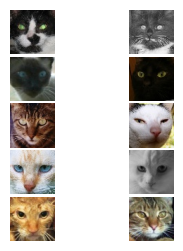

In [ ]:
# Define a function to plot a single image
def plotExampleImage(img_n):
    # Load the image using cv2.imread and save it to a variable called "img"
    img = cv2.imread(impaths[img_n])
    # Get the shape of the image using np.shape
    np.shape(img)
    # Convert the color format of the image from BGR to RGB using cv2.cvtColor
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Show the image using plt.imshow
    plt.imshow(img)
    # Turn off the axis labels using plt.axis('off')
    plt.axis('off')

# Create a new figure with size 12x8 using plt.figure
plt.figure(figsize=(3,3))

# Loop over the first 24 images in the dataset and plot each one using plotExampleImage
for k in range(10):
    # Create a subplot with 4 rows and 6 columns, and select the kth subplot
    plt.subplot(5,2,k+1)
    # Plot the kth image using plotExampleImage
    plotExampleImage(k)

# Adjust the spacing between the subplots using plt.subplots_adjust
plt.subplots_adjust(wspace=0.05, hspace=0.05)

So, by enabling NumPy-like behavior in TensorFlow, it's as if you're telling TensorFlow to understand and work with data in a way that's similar to how NumPy does things. This can make it easier for people who are familiar with NumPy to use TensorFlow without having to learn a completely different set of conventions

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

tf.random.set_seed(42) (TensorFlow):

Why: TensorFlow also uses random numbers, especially in neural network initialization and certain operations.

How: Similar to NumPy, setting the TensorFlow random seed ensures reproducibility. If you use the same seed (42), you'll get the same random behavior in TensorFlow each time you run your code.

setting random seeds helps make your code predictable. If someone else runs your code or if you need to rerun it later, having fixed seeds ensures that the randomness is consistent, making it easier to compare results or debug issues.

In [ ]:
# Define the settings for the training process
class settings:
    debug = False # Debug mode is turned off
    imsize = 64 # Image size is 64x64 pixels
    rgb = True # Images are in RGB format
    latent_dim = 256 # Dimension of the latent space
    n_samples = 0 # Number of training samples
    n_epochs = 5 # Number of training epochs
    batch_size = 16 # Batch size for training

    # Determine the number of channels in the input images
    if rgb:
        channels = 3
    else:
        channels = 1

    # If debug mode is on, increase the number of training epochs
    if debug:
        n_epochs = 70

In [ ]:
# If debug mode is on, set the number of training samples to 16 times the batch size,
# otherwise set it to the total number of images
if settings.debug:
    settings.n_samples = 16 * settings.batch_size
else:
    settings.n_samples = len(impaths)

In [ ]:
# Load and preprocess the training images
ds = []
for i in range(0, settings.n_samples):
    image = cv2.imread(impaths[i])

    # Convert the images to RGB or grayscale format as specified in the settings
    if settings.rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (settings.imsize, settings.imsize))
    ds.append(image)

In [1]:
# Convert the list of images to a numpy array and reshape it to match the input shape of the generator
train_images = np.array(ds)
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3)

NameError: name 'np' is not defined

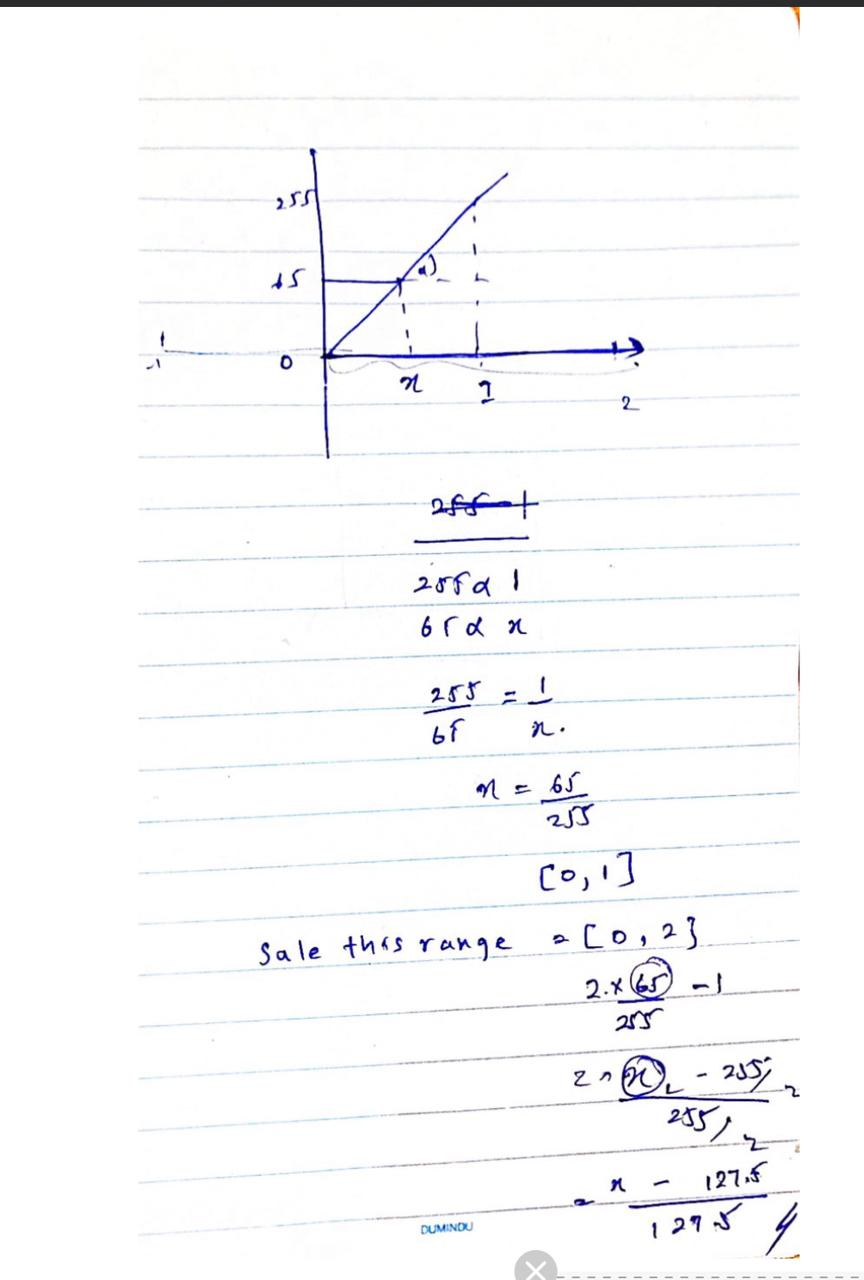

In [ ]:
# Normalize
train_images = (train_images - 127.5) / 127.5

In [ ]:
# Define the buffer size for shuffling
#this helps to evoid over fitting
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(settings.batch_size)

In [ ]:
def define_discriminator(in_shape=(settings.imsize,settings.imsize,settings.channels)):
    #mean=0.0 and stddev=0.02 are commonly used in GANs for weight initialization.
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = tf.keras.Sequential(name='Discriminator')
    # 256 -> 16*16 add padding same hence add 2 pixels each side then it will go 20*20 image
    model.add(Conv2D(256, (5,5), padding='same', input_shape=in_shape,kernel_initializer=init))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())
    # Add a LeakyReLU activation function with alpha = 0.2
    model.add(LeakyReLU(alpha=0.2))
    # Add a 2D convolutional layer with 256 filters, a 5x5 kernel size, and stride 2x2
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())
    # Add a LeakyReLU activation function with alpha = 0.2
    model.add(LeakyReLU(alpha=0.2))
    # Add a 2D convolutional layer with 256 filters, a 5x5 kernel size, and stride 2x2
    model.add(Conv2D(256, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())
    # Add a LeakyReLU activation function with alpha = 0.2
    model.add(LeakyReLU(alpha=0.2))
    # Add a 2D convolutional layer with 256 filters, a 3x3 kernel size, and stride 2x2
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same',kernel_initializer=init))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())
    # Add a LeakyReLU activation function with alpha = 0.2
    model.add(LeakyReLU(alpha=0.2))
    # Add a 2D convolutional layer with 128 filters, a 5x5 kernel size, and stride 2x2
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same',kernel_initializer=init))
    # Add batch normalization layer
    model.add(layers.BatchNormalization())
    # Add a LeakyReLU activation function with alpha = 0.2
    model.add(LeakyReLU(alpha=0.2))
    # Flatten the output of the previous layer
    model.add(Flatten())
    # Add a Dropout layer with a rate of 0.05
    model.add(Dropout(0.05))
    # Add a dense layer with one neuron and a sigmoid activation function
    model.add(Dense(1, activation='sigmoid',kernel_initializer=init))
    # Return the model
    return model

In [ ]:
def define_generator(latent_dim):
    # initialize the weights of the model using a normal distribution
    init = RandomNormal(mean=0.0, stddev=0.02)

    # define the generator model using Keras Sequential API
    model = tf.keras.Sequential(name='Generator')

    # determine the number of filters for the first convolutional layer
    n_filters = 128 * 8 * 8

    # add a fully connected layer with the given latent dimensionality as input
    model.add(Dense(n_filters, input_dim=latent_dim,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # reshape the output of the fully connected layer to be a 3D tensor
    model.add(Reshape((8, 8, 128)))

    # add a series of transposed convolutional layers with increasing number of filters and decreasing feature map size
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(256, (4,4), strides=(1,1), padding='same',kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # add a final convolutional layer with 3 output channels and tanh activation function
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same',use_bias=False))

    return model

In [ ]:
def generator_loss(fake_output):
    """
    Computes the generator loss given the discriminator's output on generated images.

    Args:
        fake_output: Discriminator's output on generated images.

    Returns:
        The generator loss as a scalar tensor.
    """
    # Generator aims to make the discriminator classify the generated images as real (ones)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    # Calculate the loss for real samples
    # Subtract a small random value to real labels to improve robustness
    real_loss = cross_entropy(tf.ones_like(real_output) - np.random.random(real_output.shape)*0.2, real_output)

    # Calculate the loss for fake samples
    # Add a small random value to fake labels to improve robustness
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + np.clip(-0.2 + np.random.random(fake_output.shape)*0.4, 0, None), fake_output)

    # Calculate the total loss as the sum of real and fake loss
    total_loss = real_loss + fake_loss

    return total_loss

In [ ]:
# Define the generator and discriminator networks
generator = define_generator(settings.latent_dim)
discriminator = define_discriminator()

# Print the summaries of the generator and discriminator networks
print('¤¤¤ Generator ¤¤¤:')
generator.summary()
print('\n\n¤¤¤ Discriminator ¤¤¤:')
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


¤¤¤ Generator ¤¤¤:
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              2105344   
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       524544    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16

In [ ]:
# Define the optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Define the loss function for the adversarial training
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

(-0.5, 63.5, 63.5, -0.5)

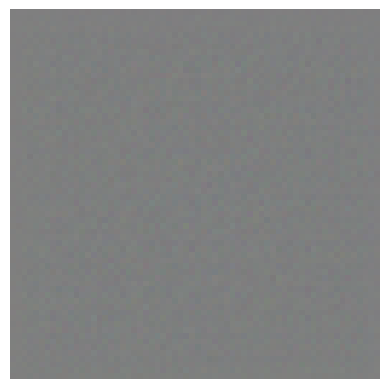

In [ ]:
# Generate a sample image from the generator for visualization
noise = tf.random.normal([1, settings.latent_dim])
generated_image = generator(noise, training=False)
testimg = np.uint8(generated_image[0, :, :, :] * 127.5 + 127.5)

# Visualize the generated image
plt.imshow(testimg)
plt.axis('off')

In [ ]:
# Create directory if it doesn't exist
if not os.path.exists('./gdrive/My Drive/image_generation/training_checkpoints'):
  os.makedirs('./gdrive/My Drive/image_generation/training_checkpoints')

# Define the directory to save the checkpoints
checkpoint_dir = './gdrive/My Drive/image_generation/training_checkpoints'

# Define the prefix for the checkpoint filenames
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define the objects to be saved in the checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Set the dimension of the noise vector
noise_dim = settings.latent_dim

In [ ]:
# Set the number of examples to generate
num_examples_to_generate = 16

# Initialize the seed tensor with random normal values
seed = tf.random.normal(shape=[num_examples_to_generate, noise_dim])

In [ ]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

# Define train_step function as a tf.function to speed up training
@tf.function
def train_step(images):
    # Generate random noise
    noise = tf.random.normal([settings.batch_size, noise_dim])

    # Calculate generator and discriminator losses with GradientTape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images with generator and get real images
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate real and fake accuracy
        real_predict = tf.cast(real_output > 0.5, tf.float32)
        real_acc = 1 - tf.reduce_mean(tf.abs(real_predict - tf.ones_like(real_predict)))
        fake_predict = tf.cast(fake_output > 0.5, tf.float32)
        fake_acc = 1 - tf.reduce_mean(tf.abs(fake_predict - tf.zeros_like(fake_predict)))

        # Get top half of fake images sorted by discriminator output, and calculate generator loss
        idx = tf.argsort(-fake_output, axis=0).numpy().reshape(-1,)
        gen_loss = generator_loss(fake_output[fake_output > fake_output[idx[int(len(idx)/2)]]*0.9])

        # Calculate discriminator loss
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients and apply to generator and discriminator variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return losses and accuracies for monitoring
    return gen_loss, disc_loss, real_acc, fake_acc

In [ ]:
def plot_trainingMetrics(G_losses, D_losses, all_gl, all_dl, epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect):
    # Define colors for the plots
    colorG = np.array([195, 60, 162])/255
    colorD = np.array([61, 194, 111])/255
    colorR = np.array([207, 91, 48])/255
    colorF = np.array([12, 181, 243])/255

    # Plot the generator and discriminator loss for the current training step
    plt.figure(figsize=(10,5))
    plt.title("Generator and discriminator loss for training step {}".format(sub_epoch_vect))
    plt.plot(G_losses, label="Generator", color=colorG)
    plt.plot(D_losses, label="Discriminator", color=colorD)
    plt.xlabel("Iterations in one training step")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()

    # Plot the all-time generator and discriminator loss
    plt.figure(figsize=(10,5))
    plt.plot(sub_epoch_vect, all_gl, label='Generator', color=colorG)
    plt.plot(sub_epoch_vect, all_dl, label='Discriminator', color=colorD)
    plt.title('All Time Loss')
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

    # Plot the all-time real and fake accuracy
    plt.figure(figsize=(10,5))
    plt.title("All Time Accuracy")
    plt.plot(sub_epoch_vect, all_racc, label="Acc: Real", color=colorR)
    plt.plot(sub_epoch_vect, all_facc, label="Acc: Fake", color=colorF)
    plt.xlabel("Iterations")
    plt.ylabel("Acc")
    plt.legend()
    plt.show()

In [ ]:
def train(dataset, epochs):
    # Initialize arrays to store losses and accuracies over time
    all_gl = np.array([])
    all_dl = np.array([])
    all_racc = np.array([])
    all_facc = np.array([])
    sub_epoch_vect = []
    sub_epoch = 0

    # Get number of batches in dataset
    n_batches = train_dataset.cardinality().numpy()

    # Loop over epochs
    for epoch in range(epochs):
        print('Starting epoch: ' +str(epoch))
        start = time.time()

        # Initialize arrays to store losses and accuracies for each batch in the epoch
        G_loss = []
        D_loss = []
        real_acc_full = []
        fake_acc_full = []
        global_step = 0

        # Loop over batches in the dataset
        for image_batch in dataset:
            # Call train_step to perform one optimization step
            g_loss,d_loss, real_acc, fake_acc = train_step(image_batch)
            global_step = global_step + 1
            sub_epoch = sub_epoch+1

            # Store losses and accuracies for the current batch
            G_loss.append(g_loss)
            D_loss.append(d_loss)
            real_acc_full.append(real_acc)
            fake_acc_full.append(fake_acc)

            # Save training metrics and generate and save images every 150 iterations for the first two epochs and every 1000 iterations thereafter
            if epoch<2:
                save_subepoch = 150
            else:
                save_subepoch = 1000
            if (sub_epoch % save_subepoch)==0:
                # Compute the mean loss and accuracy for all batches up to the current iteration and append them to the all_* arrays
                all_gl   = np.append(all_gl,np.mean(np.array([G_loss])))
                all_dl   = np.append(all_dl,np.mean(np.array([D_loss])))
                all_racc = np.append(all_racc,np.mean(np.array([real_acc_full])))
                all_facc = np.append(all_facc,np.mean(np.array([fake_acc_full])))
                sub_epoch_vect=np.append(sub_epoch_vect,sub_epoch)

                # Display training metrics and generate and save images
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch, sub_epoch + 1, seed)
                plot_trainingMetrics(G_loss, D_loss, all_gl, all_dl, sub_epoch, real_acc_full, fake_acc_full, all_racc, all_facc, sub_epoch_vect )
                print ('Time for epoch {}, global_step {}, is {} sec'.format(epoch + 1, global_step, time.time()-start))

        # Shuffle the dataset after each epoch
        dataset.shuffle

        # Save checkpoint at the end of each epoch
        checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate and save images at the end of training
    generate_and_save_images(generator, epoch, sub_epoch + 1, seed)

In [ ]:
def generate_and_save_images(model, epoch, sub_epoch, test_input):
    # Generate images using the generator model
    predictions = model(test_input, training=False)

    # Create a figure to plot the generated images
    fig = plt.figure(figsize=(12, 12))

    # Plot each generated image in a subplot
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.int32(np.array(predictions[i, :, :, :]) * 127.5 + 127.5))
        plt.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Create directory if it doesn't exist
    if not os.path.exists('./gdrive/My Drive/image_generation/saved_images'):
        os.makedirs('./gdrive/My Drive/image_generation/saved_images')

    # Save the figure as a PNG file
    plt.savefig('./gdrive/My Drive/image_generation/saved_images/image_at_epoch_{:04d}_subepoch{:08d}.png'.format(epoch,sub_epoch))

    # Display the plot
    plt.show()

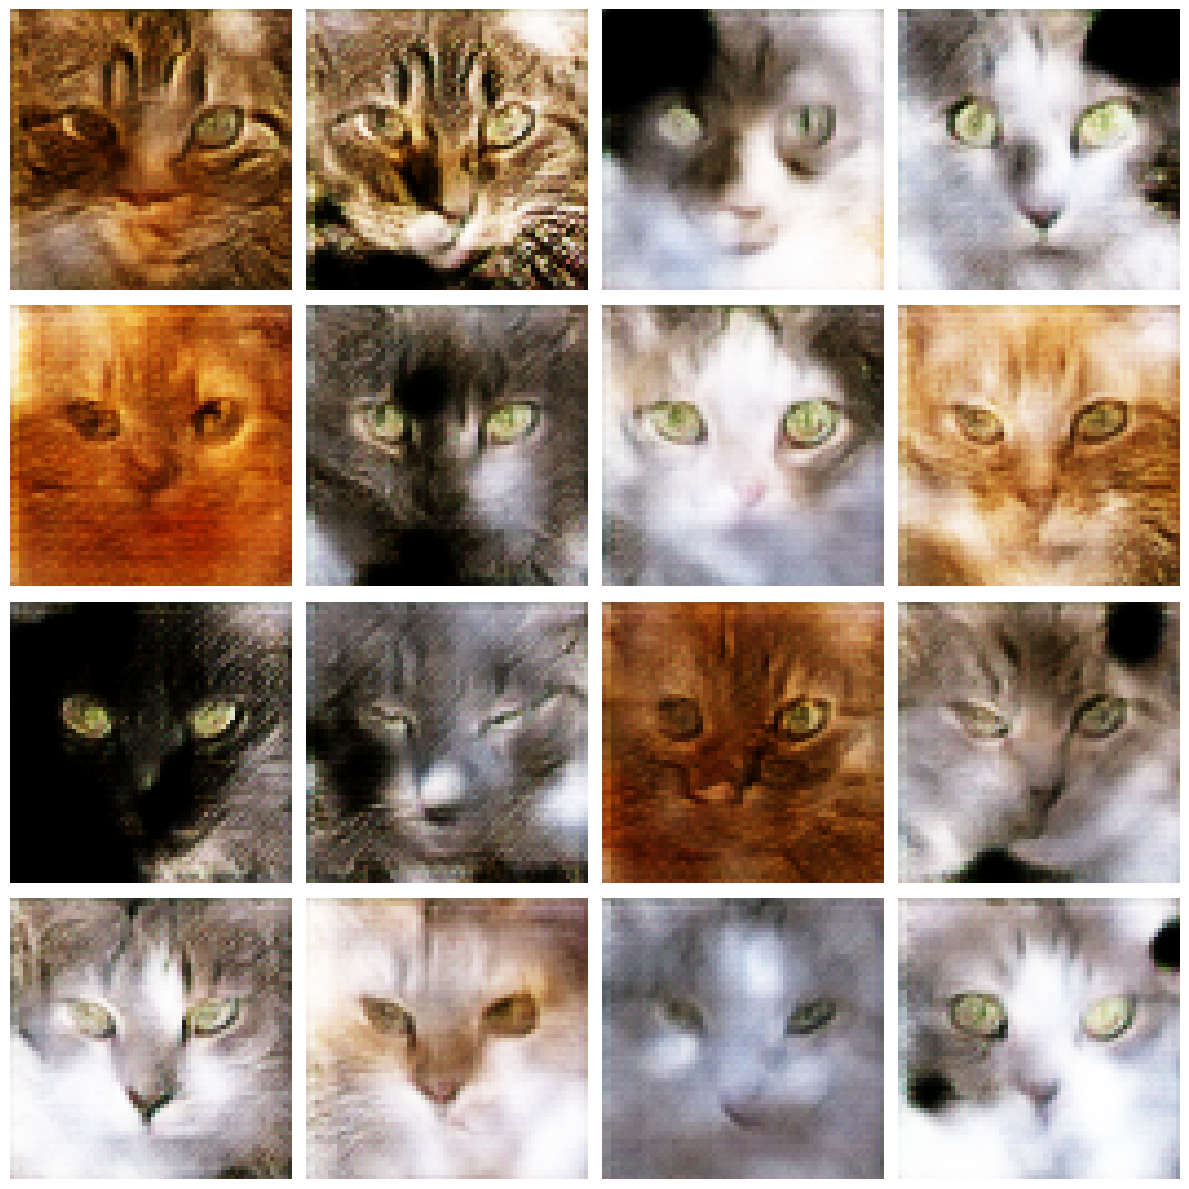

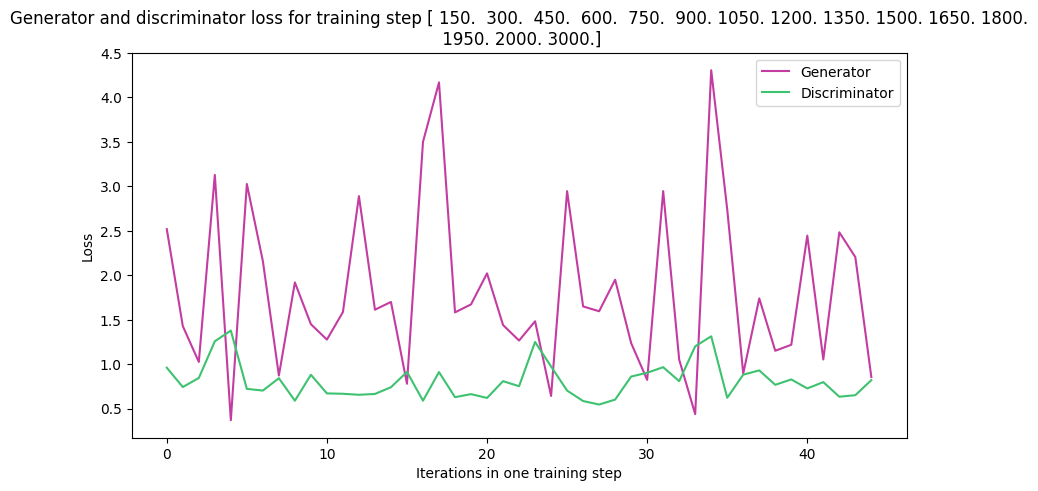

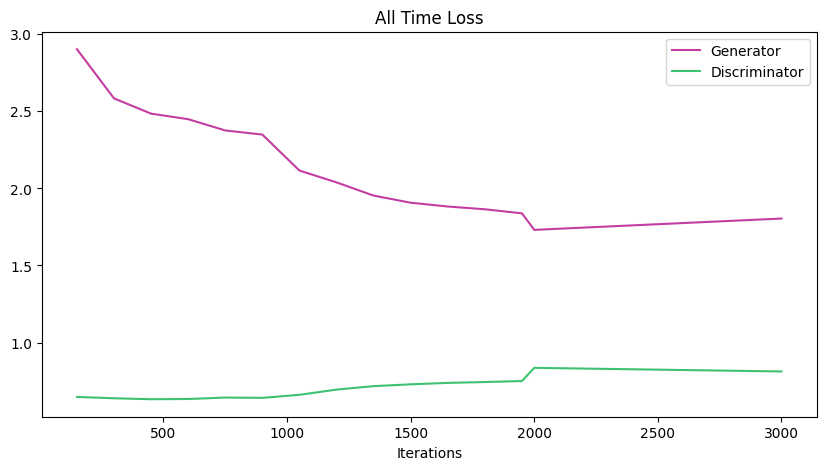

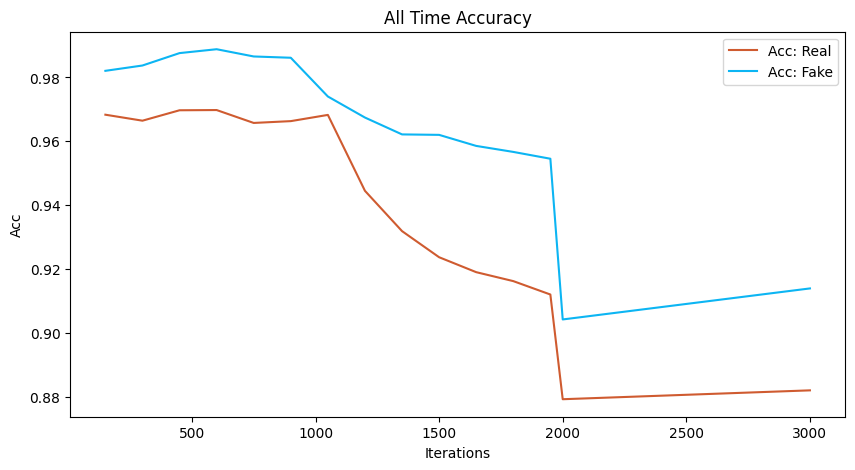

Time for epoch 4, global_step 45, is 52.99239230155945 sec
Starting epoch: 4


In [ ]:
# Training
train(train_dataset, settings.n_epochs)